# Using a support vector machine to classify Palmer Penguins üêß by species

[Palmer Penguins](https://allisonhorst.github.io/palmerpenguins/) is a dataset consisting of penguin measurements from the Palmer Archipelago in Antarctica. This notebook demonstrates the process to classify this data to species ([Adelie](https://www.antarctica.gov.au/about-antarctica/animals/penguins/adelie-penguin/), [Chinstrap](https://www.antarctica.gov.au/about-antarctica/animals/penguins/chinstrap-penguin/), or [Gentoo](https://www.antarctica.gov.au/about-antarctica/animals/penguins/gentoo-penguin/)) based on bill length, bill depth, flipper length, and body mass using a support vector machine model.

[![Latest release](https://badgen.net/github/release/Naereen/Strapdown.js)](https://github.com/dmhuehol/palmerpenguins-classifiers)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1AyZC-YdTOTHnOsVTGtAmG_4oAimKfLP7?usp=sharing)


*    Example by [Daniel Hueholt](https://hueholt.earth), PhD student at Colorado State University (CSU)
*    Borrows format from the [CSU Machine Learning Tutorial](https://zenodo.org/record/6686879)
*    For details on Palmer Penguins and cute penguin art, see the official [Palmer Penguins page at GitHub](https://allisonhorst.github.io/palmerpenguins/) or [Horst et al. 2022](doi.org/10.32614/RJ-2022-020)


In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
print('IN_COLAB = ' + str(IN_COLAB))

IN_COLAB = True


In [2]:
import matplotlib.pyplot as plt
import numpy as np
!pip install palmerpenguins # Dataset
from palmerpenguins import load_penguins
import pandas as pd # For confusion matrix
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn import metrics
from sklearn import svm
import sys

print(f"python version = {sys.version}")
print(f"scikit-learn version = {sklearn.__version__}")

python version = 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
scikit-learn version = 1.2.2


# 1. Load and look at data

In [4]:
X,y = load_penguins(return_X_y=True, drop_na=True) #drop_na removes observations with NaN values
print('--- FEATURES ---')
print(X.head())
feature_names = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
print('--- LABELS ---')
print(y.head())
classes = ['Adelie', 'Chinstrap', 'Gentoo'] # These are the penguin species

--- FEATURES ---
   bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g
0            39.1           18.7              181.0       3750.0
1            39.5           17.4              186.0       3800.0
2            40.3           18.0              195.0       3250.0
4            36.7           19.3              193.0       3450.0
5            39.3           20.6              190.0       3650.0
--- LABELS ---
0    Adelie
1    Adelie
2    Adelie
4    Adelie
5    Adelie
Name: species, dtype: object


We use the features (called `X`) to classify the data by target/label (called `y`). With this data, our targets/labels are the species of each penguin, while our features are physical measurements from each penguin.

We need to split the data into **training, validation, and testing datasets**. With Earth science data, we often need to carefully consider the method we use for this in order to prevent "data leakage" between these data splits. With penguins, this isn't a concern--so we can just use Scikit's default method to do this!

In [5]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=100,
                                                          random_state=13) # first reserve the held-back testing data
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=100,
                                                       random_state=13) # then reserve the validation data (for hyperparameter tuning)

# Commented lines below are to look at the split data
# print('--- TRAINING ---')
# print(X_train.head(), y_train.head())
# print('--- VALIDATION ---')
# print(X_val.head(), y_val.head())
# print('--- HELD-BACK TESTING --- ')
# print(X_test.head(), y_test.head())

We now have the following variables:


*   `X_train` and `y_train`: features and labels used for training
*   `X_val` and `y_val`: features and labels used for validation (hyperparameter tuning)
*   `X_test` and `y_test`: features and labels held back for testing

Now we are ready to set up the support vector machine model!

# 2. Set up and run the support vector machine

We define the tunable parameters (hyperparameters) that we'll use for the model. We put these values in a dictionary so they can easily be accessed and modified for future experiments.

Support vector machines have a very small number of hyperparameters. This makes tuning a relatively simple process compared to models like random forests or neural networks. Of course, the drawback to this is that there are fewer ways to get good performance out of a support vector machine--if it performs poorly for a problem, there's not much one can do to change that!

In [6]:
svmd = {
    "kernel": "linear",     # kernel function, ‚Äòlinear‚Äô, ‚Äòpoly‚Äô, ‚Äòrbf‚Äô, ‚Äòsigmoid‚Äô, ‚Äòprecomputed‚Äô
    "C": 1.0,               # regularization parameter, determines "size" of boundary
    "gamma": 'scale',       # similarity radius, sets how "close" points need to be to be grouped (only applies for ‚Äòrbf‚Äô, ‚Äòpoly‚Äô and ‚Äòsigmoid‚Äô)
    "decision_function_shape": 'ovr',
    "random_state": 13      # set random state for reproducibility
}

### Default values retained below for reference
# svmd = {
#     "kernel": "linear",     # kernel function, ‚Äòlinear‚Äô, ‚Äòpoly‚Äô, ‚Äòrbf‚Äô, ‚Äòsigmoid‚Äô, ‚Äòprecomputed‚Äô
#     "C": 1.0,               # regularization parameter, determines "size" of boundary
#     "gamma": 'scale',       # similarity radius, sets how "close" points need to be to be grouped (only applies for ‚Äòrbf‚Äô, ‚Äòpoly‚Äô and ‚Äòsigmoid‚Äô)
#     "random_state": 13      # set random state for reproducibility
# }

We set up the support vector machine classifier to use the hyperparameters we just specified.

In [75]:
svm_model = svm.SVC(
    kernel=svmd["kernel"],
    C=svmd["C"],
    gamma=svmd["gamma"],
    decision_function_shape=svmd["decision_function_shape"])
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_train)

     bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g
333            49.3           19.9              203.0       4050.0
76             40.9           16.8              191.0       3700.0
16             38.7           19.0              195.0       3450.0
172            50.2           14.3              218.0       5700.0
260            43.3           14.0              208.0       4575.0
..              ...            ...                ...          ...
287            51.7           20.3              194.0       3775.0
249            46.9           14.6              222.0       4875.0
25             35.3           18.9              187.0       3800.0
247            50.8           15.7              226.0       5200.0
37             42.2           18.5              180.0       3550.0

[133 rows x 4 columns]


Let's check and see how well we did on the training data using the accuracy score and a confusion matrix.

training accuracy:  100.0 %


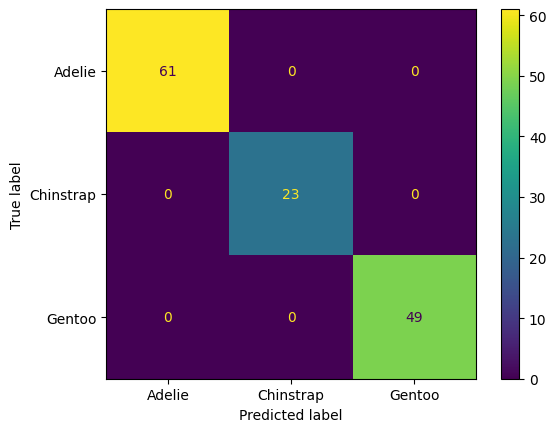

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

acc = metrics.accuracy_score(y_train, y_pred)
print("training accuracy: ", np.around(acc*100), '%')

cm = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()

Now let's try the validation data, to make sure our model applies to data it hasn't seen before.

validation accuracy:  99.0 %


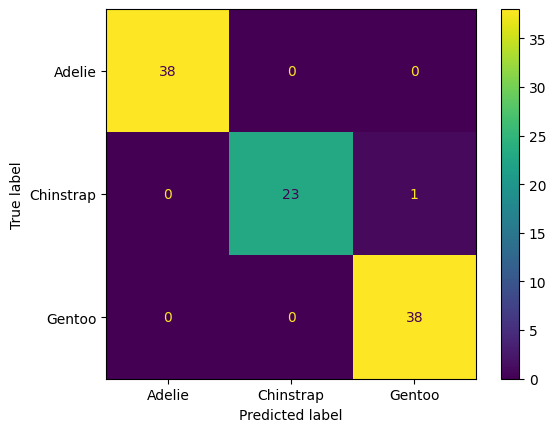

In [16]:
y_pred_val = svm_model.predict(X_val)

acc = metrics.accuracy_score(y_val, y_pred_val)
print("validation accuracy: ", np.around(acc*100), '%')
cm = confusion_matrix(y_val, y_pred_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()

Continue tuning the hyperparameters until you're happy with the validation accuracy. Since the data is linearly separable, it's very difficult to find anything better than the simple support vector machine implemented with the settings provided above!

Once you are happy with your model, you can once (and only once!) apply your model on the testing data. Before we do that, it's useful to try to understand how the model makes its decisions. This helps you to check whether it's overfitting, not successfully making decisions, or is ready to roll!

# 3. Explainability and interpretability

## 3.1 Plot the support vectors
For datasets with a relatively small number of features, we can directly plot the features pairwise and overlay the support vectors. Pairs of features where the support vectors cleanly separate the targets are useful to the model.

In [20]:
supp_vec = svm_model.support_vectors_
# Split our data up by species so we can see how well the support vectors are doing
X_train_adelie = X_train[y_train == 'Adelie']
X_train_chinstrap = X_train[y_train == 'Chinstrap']
X_train_gentoo = X_train[y_train == 'Gentoo']

# Colors for plotting
adelie_col = 'k'
chinstrap_col = '#8d6857'
gentoo_col = '#f66204'
supp_vec_col = 'g'


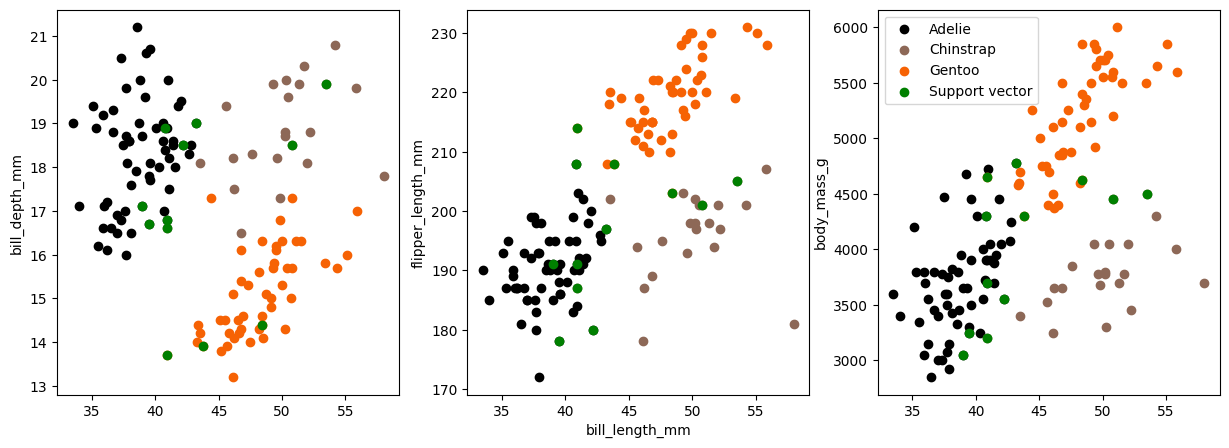

In [26]:
# --- Bill length
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.scatter(X_train_adelie['bill_length_mm'], X_train_adelie['bill_depth_mm'], color=adelie_col)
plt.scatter(X_train_chinstrap['bill_length_mm'], X_train_chinstrap['bill_depth_mm'], color=chinstrap_col)
plt.scatter(X_train_gentoo['bill_length_mm'], X_train_gentoo['bill_depth_mm'], color=gentoo_col)
plt.scatter(supp_vec[:,0], supp_vec[:,1], color=supp_vec_col)
plt.ylabel('bill_depth_mm')

plt.subplot(1,3,2)
plt.scatter(X_train_adelie['bill_length_mm'], X_train_adelie['flipper_length_mm'], color=adelie_col)
plt.scatter(X_train_chinstrap['bill_length_mm'], X_train_chinstrap['flipper_length_mm'], color=chinstrap_col)
plt.scatter(X_train_gentoo['bill_length_mm'], X_train_gentoo['flipper_length_mm'], color=gentoo_col)
plt.scatter(supp_vec[:,0], supp_vec[:,2], color=supp_vec_col)
plt.ylabel('flipper_length_mm')
plt.xlabel('bill_length_mm')

plt.subplot(1,3,3)
plt.scatter(X_train_adelie['bill_length_mm'], X_train_adelie['body_mass_g'], color=adelie_col, label='Adelie')
plt.scatter(X_train_chinstrap['bill_length_mm'], X_train_chinstrap['body_mass_g'], color=chinstrap_col, label='Chinstrap')
plt.scatter(X_train_gentoo['bill_length_mm'], X_train_gentoo['body_mass_g'], color=gentoo_col, label='Gentoo')
plt.scatter(supp_vec[:,0], supp_vec[:,3], color=supp_vec_col, label='Support vector')
plt.ylabel('body_mass_g')
plt.legend()

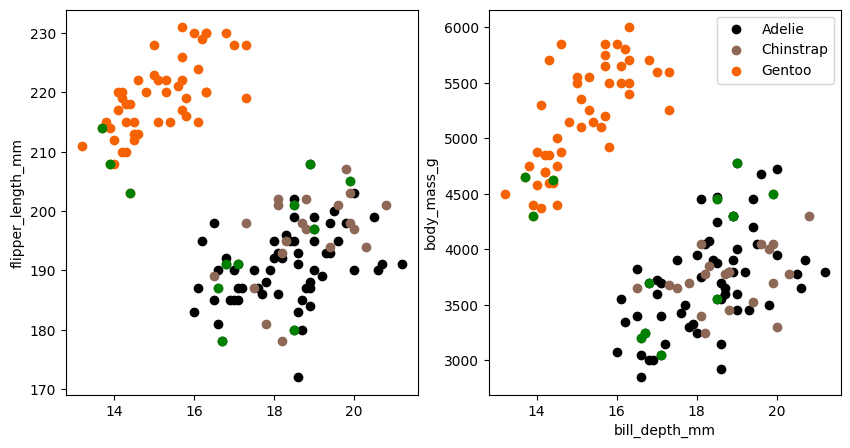

In [22]:
# --- Bill depth
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(X_train_adelie['bill_depth_mm'], X_train_adelie['flipper_length_mm'], color=adelie_col)
plt.scatter(X_train_chinstrap['bill_depth_mm'], X_train_chinstrap['flipper_length_mm'], color=chinstrap_col)
plt.scatter(X_train_gentoo['bill_depth_mm'], X_train_gentoo['flipper_length_mm'], color=gentoo_col)
plt.scatter(supp_vec[:,1], supp_vec[:,2], color=supp_vec_col)
plt.ylabel('flipper_length_mm')

plt.subplot(1,2,2)
plt.scatter(X_train_adelie['bill_depth_mm'], X_train_adelie['body_mass_g'], color=adelie_col, label='Adelie')
plt.scatter(X_train_chinstrap['bill_depth_mm'], X_train_chinstrap['body_mass_g'], color=chinstrap_col, label='Chinstrap')
plt.scatter(X_train_gentoo['bill_depth_mm'], X_train_gentoo['body_mass_g'], color=gentoo_col, label='Gentoo')
plt.scatter(supp_vec[:,1], supp_vec[:,3], color=supp_vec_col)
plt.ylabel('body_mass_g')
plt.xlabel('bill_depth_mm')
plt.legend()


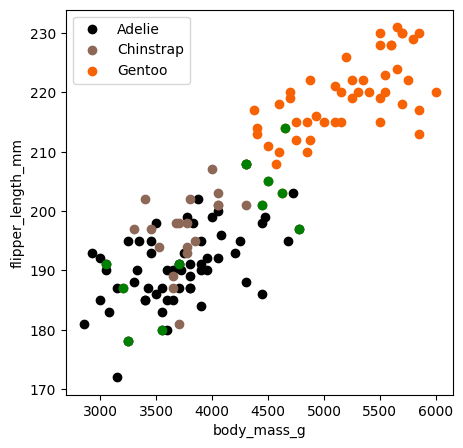

In [23]:
# --- Body mass
plt.figure(figsize=(5,5))
plt.scatter(X_train_adelie['body_mass_g'], X_train_adelie['flipper_length_mm'], color=adelie_col, label='Adelie')
plt.scatter(X_train_chinstrap['body_mass_g'], X_train_chinstrap['flipper_length_mm'], color=chinstrap_col, label='Chinstrap')
plt.scatter(X_train_gentoo['body_mass_g'], X_train_gentoo['flipper_length_mm'], color=gentoo_col, label='Gentoo')
plt.scatter(supp_vec[:,3], supp_vec[:,2], color=supp_vec_col)
plt.ylabel('flipper_length_mm')
plt.xlabel('body_mass_g')
plt.legend()

Similar information can be obtained by plotting the *decision boundaries*, that is, the surfaces that separate different classes. However, this requires that the model be re-fit for each pairwise combination: it does not appear that this can be extracted from the trained high-dimensional svm_model.

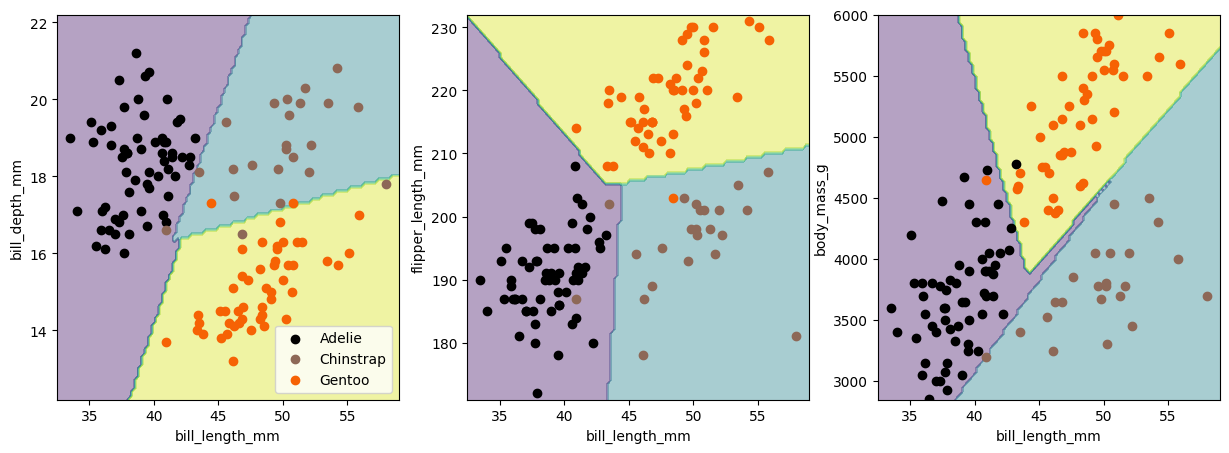

In [121]:
from itertools import product
from sklearn.inspection import DecisionBoundaryDisplay
# --- Bill length
f_n = ['bill_length_mm', 'bill_depth_mm']
plt.figure(figsize=(15,5))
axe = plt.subplot(1,3,1)
clf_2d = svm_model.fit(X_train[f_n], y_train)
DecisionBoundaryDisplay.from_estimator(
    clf_2d, X_train[f_n], alpha=0.4, ax=axe, response_method="predict"
)
plt.scatter(
    X_train_adelie[f_n[0]], X_train_adelie[f_n[1]],
    color=adelie_col, label='Adelie')
plt.scatter(
    X_train_chinstrap[f_n[0]], X_train_chinstrap[f_n[1]],
    color=chinstrap_col, label='Chinstrap')
plt.scatter(
    X_train_gentoo[f_n[0]], X_train_gentoo[f_n[1]],
    color=gentoo_col, label='Gentoo')
plt.legend()

axe = plt.subplot(1,3,2)
f_n = ['bill_length_mm', 'flipper_length_mm']
clf_2d = svm_model.fit(X_train[f_n], y_train)
DecisionBoundaryDisplay.from_estimator(
    clf_2d, X_train[f_n], alpha=0.4, ax=axe, response_method="predict"
)
plt.scatter(
    X_train_adelie[f_n[0]], X_train_adelie[f_n[1]],
    color=adelie_col, label='Adelie')
plt.scatter(
    X_train_chinstrap[f_n[0]], X_train_chinstrap[f_n[1]],
    color=chinstrap_col, label='Chinstrap')
plt.scatter(
    X_train_gentoo[f_n[0]], X_train_gentoo[f_n[1]],
    color=gentoo_col, label='Gentoo')

axe = plt.subplot(1,3,3)
f_n = ['bill_length_mm', 'body_mass_g']
clf_2d = svm_model.fit(X_train[f_n], y_train)
DecisionBoundaryDisplay.from_estimator(
    clf_2d, X_train[f_n], alpha=0.4, ax=axe, response_method="predict"
)
plt.scatter(
    X_train_adelie[f_n[0]], X_train_adelie[f_n[1]],
    color=adelie_col, label='Adelie')
plt.scatter(
    X_train_chinstrap[f_n[0]], X_train_chinstrap[f_n[1]],
    color=chinstrap_col, label='Chinstrap')
plt.scatter(
    X_train_gentoo[f_n[0]], X_train_gentoo[f_n[1]],
    color=gentoo_col, label='Gentoo')

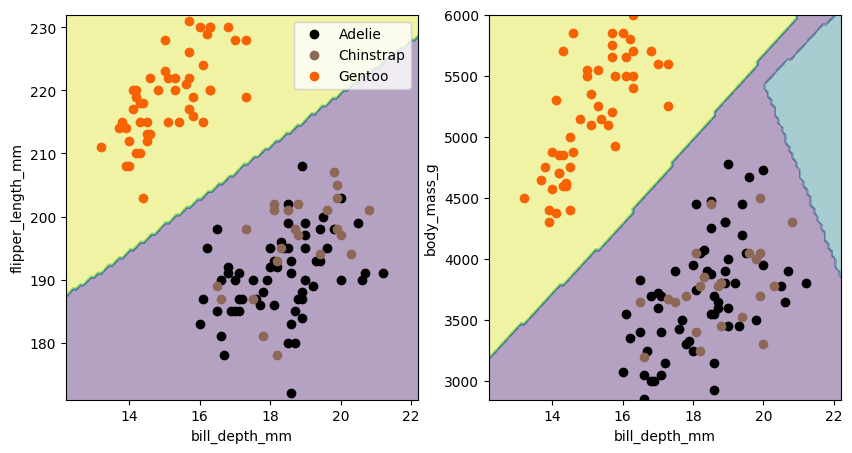

In [120]:
# --- Bill depth
plt.figure(figsize=(10,5))

axe = plt.subplot(1,2,1)
f_n = ['bill_depth_mm', 'flipper_length_mm']
clf_2d = svm_model.fit(X_train[f_n], y_train)
DecisionBoundaryDisplay.from_estimator(
    clf_2d, X_train[f_n], alpha=0.4, ax=axe, response_method="predict"
)
plt.scatter(
    X_train_adelie[f_n[0]], X_train_adelie[f_n[1]],
    color=adelie_col, label='Adelie')
plt.scatter(
    X_train_chinstrap[f_n[0]], X_train_chinstrap[f_n[1]],
    color=chinstrap_col, label='Chinstrap')
plt.scatter(
    X_train_gentoo[f_n[0]], X_train_gentoo[f_n[1]],
    color=gentoo_col, label='Gentoo')
plt.legend()

axe = plt.subplot(1,2,2)
f_n = ['bill_depth_mm', 'body_mass_g']
clf_2d = svm_model.fit(X_train[f_n], y_train)
DecisionBoundaryDisplay.from_estimator(
    clf_2d, X_train[f_n], alpha=0.4, ax=axe,
    response_method="predict"
)
plt.scatter(
    X_train_adelie[f_n[0]], X_train_adelie[f_n[1]],
    color=adelie_col, label='Adelie')
plt.scatter(
    X_train_chinstrap[f_n[0]], X_train_chinstrap[f_n[1]],
    color=chinstrap_col, label='Chinstrap')
plt.scatter(
    X_train_gentoo[f_n[0]], X_train_gentoo[f_n[1]],
    color=gentoo_col, label='Gentoo')

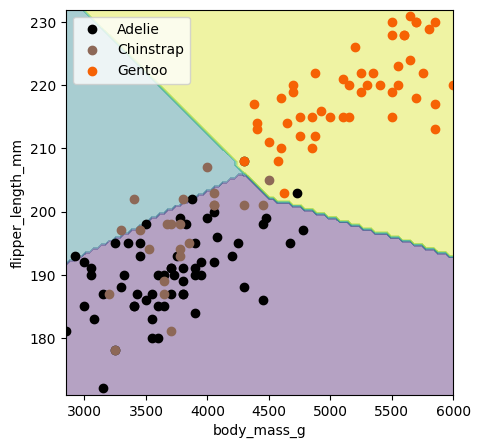

In [126]:
# --- Body mass
plt.figure(figsize=(5,5))
axe = plt.subplot(1,1,1)
f_n = ['body_mass_g', 'flipper_length_mm']
clf_2d = svm_model.fit(X_train[f_n], y_train)
DecisionBoundaryDisplay.from_estimator(
    clf_2d, X_train[f_n], alpha=0.4, ax=axe,
    response_method="predict"
)
plt.scatter(
    X_train_adelie[f_n[0]], X_train_adelie[f_n[1]],
    color=adelie_col, label='Adelie')
plt.scatter(
    X_train_chinstrap[f_n[0]], X_train_chinstrap[f_n[1]],
    color=chinstrap_col, label='Chinstrap')
plt.scatter(
    X_train_gentoo[f_n[0]], X_train_gentoo[f_n[1]],
    color=gentoo_col, label='Gentoo')
plt.legend()

This approach functions quite well to understand how our SVM works in this simple application. However, it is clear that this will not be practical in a model with many features. Thus, while SVMs may be interpretable in principle, they may be quite opaque in practice. (This is similar to the drawbacks of analyzing random forests by looking at individual decision trees--this just doesn't scale with the number of features!)

# 4. Run support vector machine classifier on testing data

Once you're happy with your model in its final form, run your SVM on the testing data!

held-back testing accuracy:  97.0 *


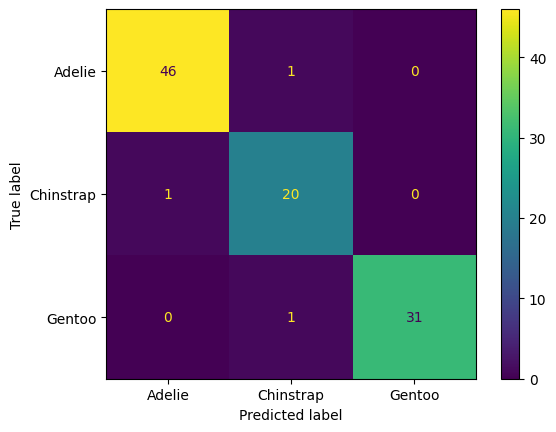

In [129]:
svm_model.fit(X_train, y_train) #Ensure training on full dataset after Section 3
y_pred_test = svm_model.predict(X_test)

acc = metrics.accuracy_score(y_test, y_pred_test)
print("held-back testing accuracy: ", np.around(acc*100), '*')
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
plt.grid(False)
plt.show()

üêß